# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import roc_auc_score

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
# azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
# customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')
azdias = pd.read_csv('azdias.csv', low_memory=False)
customers = pd.read_csv('customers.csv', low_memory=False)

In [3]:
azdias = azdias.drop('Unnamed: 0', axis=1)

In [4]:
azdias.shape

(891221, 366)

In [5]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [6]:
customers = customers.drop('Unnamed: 0', axis=1)

In [7]:
customers.shape

(191652, 369)

In [8]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


### Process missing data

Some values of attributes mean unknown or not available, we need to convert them to NaNs before process missing data.

In [9]:
# load attributes information levels dataset
attributes_info_levels = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx')
attributes_info_levels.head(10)

,Unnamed: 0,Information level,Attribute,Description,Additional notes
0,NaN,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,NaN,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,NaN,ANREDE_KZ,gender,NaN
3,NaN,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
5,NaN,NaN,FINANZ_SPARER,financial typology: money saver,NaN
6,NaN,NaN,FINANZ_VORSORGER,financial typology: be prepared,NaN
7,NaN,NaN,FINANZ_ANLEGER,financial typology: investor,NaN
8,NaN,NaN,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN
9,NaN,NaN,FINANZ_HAUSBAUER,financial typology: main focus is the own house,NaN


In [10]:
# load attributes values dataset
attributes_information = pd.read_excel('DIAS Attributes - Values 2017.xlsx')
attributes_values = attributes_information.copy()
attributes_values.drop('Unnamed: 0', axis=1, inplace=True)
attributes_values.head(20)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,1,< 30 years
7,NaN,NaN,2,30 - 45 years
8,NaN,NaN,3,46 - 60 years
9,NaN,NaN,4,> 60 years


In [11]:
# The values meaning unknown or no values need to be changed to NaNs
# first, fill the NaNs in Attribute column
attributes_values['Attribute'] = attributes_values['Attribute'].fillna(method='ffill')

In [12]:
attributes_values.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,NaN,1,< 30 years
7,ALTERSKATEGORIE_GROB,NaN,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,NaN,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,NaN,4,> 60 years


In [13]:
# find out the subset of the meaning column containing 'unknown' or 'no '
attributes_unknown = attributes_values[attributes_values['Meaning'].str.contains("unknown|no ").astype(bool)]
attributes_unknown.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown
48,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown
49,BIP_FLAG,NaN,0,no company in the building
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
105,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown


In [14]:
# create a dataframe including the attributes and the values meaning unknown.
unknown_values = attributes_unknown[['Attribute', 'Value']]
unknown_values['Value'] = unknown_values.loc[:, 'Value'].astype(str)
unknown_values = unknown_values.groupby('Attribute')['Value'].apply(', '.join).reset_index()
unknown_values['Value'] = unknown_values.loc[:, 'Value'].str.split(', ')

/Users/lizhen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
unknown_values.head(10)

,Attribute,Value
0,AGER_TYP,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,"[-1, 0]"
2,ALTER_HH,[0]
3,ANREDE_KZ,"[-1, 0]"
4,BALLRAUM,[-1]
5,BIP_FLAG,"[-1, 0]"
6,CAMEO_DEUG_2015,[-1]
7,CAMEO_DEUINTL_2015,[-1]
8,CJT_GESAMTTYP,[0]
9,D19_BANKEN_ANZ_12,[0]


In [16]:
# convert the unknown values in azdias to NaNs
for att in unknown_values['Attribute']:
    if att in azdias.columns:
        azdias_unknown = azdias.loc[:, att].isin(unknown_values.loc[unknown_values['Attribute']==att, 'Value'].iloc[0])
        azdias.loc[azdias_unknown, att] = np.nan
    else:
        continue
azdias.head(10)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0
1,910220,NaN,9.0,NaN,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0
2,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0
3,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0
4,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0
5,910244,3.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,5.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4.0,2.0,1.0
6,910248,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,2.0,7.0,10.0,10.0,3.0,9.0,5.0,4.0,2.0,2.0
7,910261,NaN,1.0,14.0,NaN,NaN,NaN,NaN,14.0,6.0,...,2.0,10.0,12.0,9.0,5.0,9.0,1.0,1.0,1.0,1.0
8,645145,NaN,9.0,16.0,NaN,NaN,NaN,NaN,16.0,2.0,...,4.0,8.0,11.0,8.0,5.0,8.0,1.0,6.0,1.0,3.0
9,645153,NaN,5.0,17.0,NaN,NaN,NaN,NaN,17.0,9.0,...,4.0,1.0,1.0,1.0,4.0,3.0,7.0,4.0,2.0,3.0


In [17]:
azdias.isnull().sum()

LNR                                0
AGER_TYP                      685843
AKT_DAT_KL                     73499
ALTER_HH                      310267
ALTER_KIND1                   810163
ALTER_KIND2                   861722
ALTER_KIND3                   885051
ALTER_KIND4                   890016
ALTERSKATEGORIE_FEIN          262947
ANZ_HAUSHALTE_AKTIV            93148
ANZ_HH_TITEL                   97008
ANZ_KINDER                     73499
ANZ_PERSONEN                   73499
ANZ_STATISTISCHE_HAUSHALTE     93148
ANZ_TITEL                      73499
ARBEIT                         97216
BALLRAUM                       93740
CAMEO_DEU_2015                 98979
CAMEO_DEUG_2015                98979
CAMEO_INTL_2015                98979
CJT_GESAMTTYP                   4854
CJT_KATALOGNUTZER               4854
CJT_TYP_1                       4854
CJT_TYP_2                       4854
CJT_TYP_3                       4854
CJT_TYP_4                       4854
CJT_TYP_5                       4854
C

Now process the missing values in columns and rows.

Text(0.5, 1.0, 'Distribution of missing values per column')

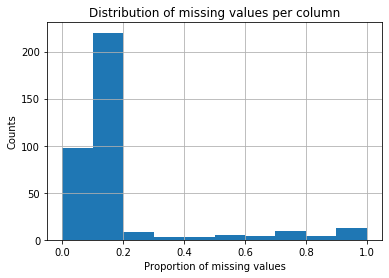

In [18]:
# find the proportion of missing value in each column
missing_value_col = azdias.isnull().sum()/ azdias.shape[0]
missing_value_col.hist()
plt.xlabel('Proportion of missing values')
plt.ylabel('Counts')
plt.title('Distribution of missing values per column')

According to this figure, the proportions of missing values in most of columns are less than 0.3. We drop the columns with the proportion of missing values greater than 0.3. 

In [19]:
# drop the columns with proportion of missing values greater than 0.3
col_missing_to_drop = missing_value_col[missing_value_col>0.3].index
azdias_new = azdias.drop(col_missing_to_drop, axis=1)

In [20]:
azdias_new.shape

(891221, 325)

In [21]:
col_missing_to_drop

Index(['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3',
       'ALTER_KIND4', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24',
       'D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24',
       'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM',
       'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM',
       'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM',
       'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24',
       'EXTSEL992', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4',
       'KBA05_BAUMAX', 'KBA05_MAXVORB', 'KK_KUNDENTYP', 'LP_STATUS_GROB',
       'TITEL_KZ'],
      dtype='object')

Text(0.5, 1.0, 'Distribution of missing values per row')

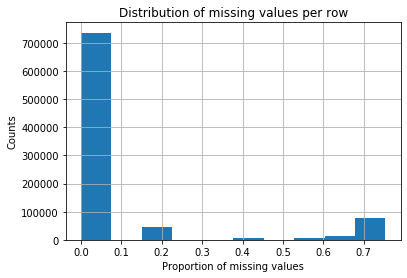

In [22]:
# find proportion of missing value in each row

missing_value_row = azdias_new.isnull().sum(axis=1)/ azdias_new.shape[1]
missing_value_row.hist()
plt.xlabel('Proportion of missing values')
plt.ylabel('Counts')
plt.title('Distribution of missing values per row')

According to this figure, the proportions of missing values in most of rows are less than 0.1. We drop the rows with the proportion of missing values greater than 0.1. 

In [23]:
# drop the rows with the proportion of missing values greater than 0.1
row_to_drop = missing_value_row[missing_value_row>0.1].index
azdias_new = azdias_new.drop(row_to_drop, axis=0)

In [24]:
azdias_new.shape

(737241, 325)

### Convert data type

In [25]:
azdias_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 737241 entries, 1 to 891220
Columns: 325 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(278), int64(41), object(6)
memory usage: 1.8+ GB


There are 6 columns having object type data. They need to be converted to numerical type.

In [26]:
# find out the columns where the data type is object
azdias_object = azdias_new.select_dtypes(include=['object'])

In [27]:
azdias_object.head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
1,8A,8.0,51.0,NaN,1992-02-10 00:00:00,W
2,4C,4.0,24.0,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2.0,12.0,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6.0,43.0,D19_SCHUHE,1992-02-12 00:00:00,W
5,8C,8.0,54.0,D19_ENERGIE,1992-02-12 00:00:00,W


In [28]:
for col in azdias_object.columns:
    print(azdias_object[col].value_counts())

6B    54003
8A    50770
4C    43987
2D    32904
7A    32626
3C    32562
3D    32174
8B    31261
4A    30254
8C    30147
9D    26743
9B    25886
9C    22918
7B    22918
9A    20057
2C    17741
8D    16673
6E    15598
5D    14070
2B    14041
6C    13868
2A    11921
1D    11456
1A    10165
5A     9720
5B     9691
5C     9050
4B     8284
7C     8127
4D     8051
6A     6414
3A     5870
6D     5756
3B     5709
6F     5048
4E     5005
1E     4782
7D     4430
7E     4374
1C     4012
5F     3939
9E     3841
1B     3815
5E     3241
XX      284
Name: CAMEO_DEU_2015, dtype: int64
8      74750
6      58201
9      57470
4      55290
8.0    54101
2      44418
3      44187
6.0    42486
9.0    41975
7      41855
4.0    40291
2.0    32189
3.0    32128
7.0    30620
5      28975
5.0    20736
1      19836
1.0    14394
X        284
Name: CAMEO_DEUG_2015, dtype: int64
51      73254
51.0    53063
41      50258
24      49089
41.0    36547
24.0    35511
14      33994
43      31170
54      24640
14.0    24478
43

In [29]:
# reencode 'X' in CAMEO_DEUG_2015 and 'XX' in CAMEO_INTL_2015 with NaNs
# convert CAMEO_DEUG_2015 and CAMEO_INTL_2015 to float
azdias_new['CAMEO_DEUG_2015'].replace('X', np.nan, inplace=True)
azdias_new['CAMEO_INTL_2015'].replace('XX', np.nan, inplace=True)

col_to_float = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']
azdias_new[col_to_float] = azdias_new[col_to_float].astype(float)

In [30]:
# reencode 'W' and 'O' in OST_WEST_KZ with 1 and 0
azdias_new['OST_WEST_KZ'].replace({'W': 1, 'O': 0}, inplace=True)
azdias_new['OST_WEST_KZ'].head()

1    1
2    1
3    1
4    1
5    1
Name: OST_WEST_KZ, dtype: int64

In [31]:
azdias_new['OST_WEST_KZ'].value_counts()

1    582247
0    154994
Name: OST_WEST_KZ, dtype: int64

In [32]:
# drop column CAMEO_DEU_2015, D19_LETZTER_KAUF_BRANCHE, EINGEFUEGT_AM
col_to_drop = ['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM']
azdias_new.drop(col_to_drop, axis=1, inplace=True)

In [33]:
azdias_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 737241 entries, 1 to 891220
Columns: 322 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(280), int64(42)
memory usage: 1.8 GB


In [34]:
azdias_new.shape

(737241, 322)

### Create functions for cleaning process

In [35]:
# create functions for the cleaning process

def get_unknown_attributes(attributes_values):
    """
    get unknown values of each attribute
    
    INPUT:
        attributes_values: dataframe of attributes
        
    OUTPUT:
        dataframe including attribute and values meaning unknown
    """
    
    # fill the NaNs in Attribute column
    attributes_values['Attribute'] = attributes_values['Attribute'].fillna(method='ffill')
    
    # find out the subset of the meaning column containing 'unknown' or 'no '
    attributes_unknown = attributes_values[attributes_values['Meaning'].str.contains("unknown|no ").astype(bool)]
    unknown_values = attributes_unkown[['Attribute', 'Value']]
    unknown_values['Value'] = unknown_values.loc[:, 'Value'].astype(str)
    unknown_values = unknown_values.groupby('Attribute')['Value'].apply(', '.join).reset_index()
    unknown_values['Value'] = unknown_values.loc[:, 'Value'].str.split(', ')
    
    return unknown_values


def convert_unknown(data, unknown_values):
    """
    convert the values in data that mean unknown to NaNs 
    
    INPUT:
        data: demographic dataframe 
    
    OUTPUT:
        demographic dataframe with values meaning unknown converted to NaNs
    """

    for att in unknown_values['Attribute']:
        if att in data.columns:
            data_unknown = data.loc[:, att].isin(unknown_values.loc[unknown_values['Attribute']==att, 'Value'].iloc[0])
            data.loc[data_unknown, att] = np.nan
        else:
            continue
    
    return data
    
def cleaning_data(data):
    """
    cleaning data
    
    INPUT:
        data: demographic dataframe 
    
    OUTPUT:
        demographic dataframe with clean data for machine learning
    """
    
    # find proportion of missing value in each column
    missing_value_col = data.isnull().sum()/ data.shape[0]
           
    # drop the columns which are dropped in azdias dataset
    col_missing_to_drop = ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3',
       'ALTER_KIND4', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24',
       'D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24',
       'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM',
       'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM',
       'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM',
       'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24',
       'EXTSEL992', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4',
       'KBA05_BAUMAX', 'KBA05_MAXVORB', 'KK_KUNDENTYP', 'LP_STATUS_GROB',
       'TITEL_KZ']
    data_new = data.drop(col_missing_to_drop, axis=1)
    
    # find proportion of missing value in each row
    missing_value_row = data_new.isnull().sum(axis=1)/ data_new.shape[1]
    
    # drop the rows with the proportion of missing values greater than 0.1
    data_new = data_new.drop(missing_value_row[missing_value_row>0.1].index, axis=0)
    
    # find columns with object data type
    data_object = data_new.select_dtypes(include=['object'])
    
    # reencode 'X' in CAMEO_DEUG_2015 and 'XX' in CAMEO_INTL_2015 with NaNs
    # convert CAMEO_DEUG_2015 and CAMEO_INTL_2015 to float
    data_new['CAMEO_DEUG_2015'].replace('X', np.nan, inplace=True)
    data_new['CAMEO_INTL_2015'].replace('XX', np.nan, inplace=True)

    col_to_float = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']
    data_new[col_to_float] = data_new[col_to_float].astype(float)

    # reencode 'W' and 'O' in OST_WEST_KZ with 1 and 0
    data_new['OST_WEST_KZ'].replace({'W': 1, 'O': 0}, inplace=True)
    
    # drop column CAMEO_DEU_2015, D19_LETZTER_KAUF_BRANCHE, EINGEFUEGT_AM
    col_to_drop = ['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM']
    data_new.drop(col_to_drop, axis=1, inplace=True)
    
    return data_new


### Process customer data

In [36]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [37]:
customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis=1, inplace=True)

In [38]:
customers = convert_unknown(customers, unknown_values)

In [39]:
customers_new = cleaning_data(customers)

In [40]:
customers_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134245 entries, 0 to 191651
Columns: 322 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(280), int64(42)
memory usage: 330.8 MB


In [41]:
customers_new.shape

(134245, 322)

### Impute data

In [42]:
azdias_new_columns = azdias_new.columns
customers_new_columns = customers_new.columns

In [43]:
# impute NaNs 

imputer = Imputer()

azdias_new = imputer.fit_transform(azdias_new)
azdias_new = pd.DataFrame(azdias_new, columns=azdias_new_columns)

customers_new = imputer.fit_transform(customers_new)
customers_new = pd.DataFrame(customers_new, columns=customers_new_columns)


/Users/lizhen/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [44]:
azdias_new.isnull().sum().sum()

0

### Feature scaling

In [45]:
scaler = StandardScaler()

azdias_new = scaler.fit_transform(azdias_new)
azdias_new = pd.DataFrame(azdias_new, columns=azdias_new_columns)

customers_new = scaler.fit_transform(customers_new)
customers_new = pd.DataFrame(customers_new, columns=customers_new_columns)


In [46]:
azdias_new.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1.057638,1.262234,1.641709,0.186864,-0.125874,-0.299071,0.224654,0.335474,-0.060662,-0.179353,...,1.373215,0.701083,1.068027,1.463729,-6.975599e-01,0.547792,-0.028607,1.141241,0.958491,-1.682076
1,1.057657,1.262234,0.748256,0.120673,-0.125874,-0.299071,-0.634491,-0.031831,-0.060662,-0.179353,...,-0.358740,1.052462,0.453530,0.028376,-6.975599e-01,0.547792,-1.083200,1.141241,0.958491,0.168039
2,1.057661,-0.934322,-0.145197,-0.475050,-0.125874,-0.299071,-1.493636,-0.399136,-0.060662,-1.185241,...,-2.090696,0.349703,0.760779,1.822568,5.224245e-16,0.547792,1.553283,-0.279639,0.958491,1.093097
3,1.057719,-0.934322,0.078166,-0.342667,-0.125874,-0.299071,1.942944,-0.325675,-0.060662,0.826534,...,-0.358740,-1.055814,-0.775463,-0.689301,-1.285758e+00,0.547792,-0.555904,0.430801,-1.043307,0.168039
4,1.057731,-0.934322,-0.815288,-0.210285,-0.125874,-0.299071,-0.634491,-0.399136,-0.060662,-1.185241,...,-0.358740,1.403841,-0.160966,-0.689301,1.067033e+00,0.547792,1.553283,0.430801,0.958491,-1.682076


Datasets are cleaned and ready for analysis.

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.


In [47]:
azdias_new.shape

(737241, 322)

In [48]:
customers_new.shape

(134245, 322)

### PCA

In [49]:
# using PCA to reduce dimension.
def do_pca(n_components, data):
    pca_fit = PCA(n_components).fit(data)
    pca_transform = pca_fit.transform(data)

    
    return pca_fit, pca_transform

Text(0, 0.5, 'cumulative variance explained')

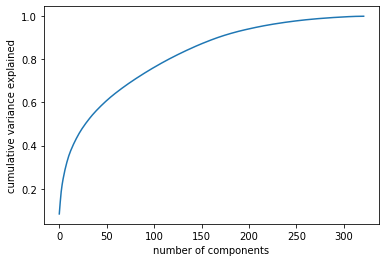

In [50]:
azdias_pca_fit, azdias_pca_transf = do_pca(None, azdias_new)
plt.figure()
plt.plot(np.cumsum(azdias_pca_fit.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative variance explained')

According to the figure, select 200 components and redo PCA

Text(0, 0.5, 'cumulative variance explained')

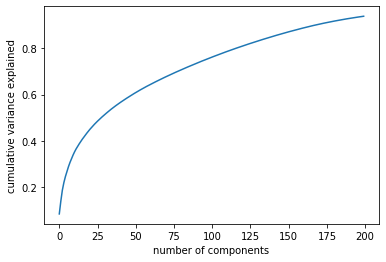

In [51]:
# select 200 components and redo PCA
azdias_pca_200_fit, azdias_pca_200_transf = do_pca(200, azdias_new)
plt.plot(np.cumsum(azdias_pca_200_fit.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative variance explained')

In [52]:
azdias_pca_200_transf.shape

(737241, 200)

In [53]:
# transform customers data using same 200 components
customers_pca_200_transf = azdias_pca_200_fit.transform(customers_new)

### Clustering

In [54]:
def get_cluster_score(data, k):
    """
    get the score of Kmeans model
    
    INPUT:
        data: dataframe for Kmeans
        k: int, number of clusters
    
    OUTPUT:
        score of Kmeans model
    """
    kmeans = KMeans(k)
    model = kmeans.fit(data)
    score = model.score(data)
    return abs(score)

In [55]:
# find the change of scores with the number of clusters.
scores = []
for i in range(1, 21):
    scores.append(get_cluster_score(azdias_pca_200_transf[:100000], i))
clusters = range(1, 21)


Text(0, 0.5, 'Distances')

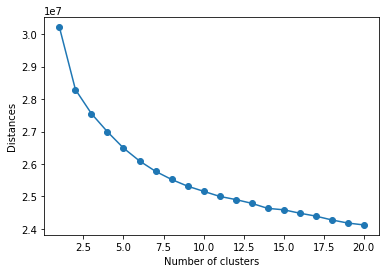

In [56]:
plt.plot(clusters, scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distances')

The plot shows that the score decreases rapidly at the beginning and then becomes slow after 9 clusters. Select 9 clusters as the number of clusters for analysis.

In [57]:
azdias_kmeans = KMeans(9)
azdias_model = azdias_kmeans.fit(azdias_pca_200_transf)
azdias_predicted = azdias_model.predict(azdias_pca_200_transf)

In [58]:
azdias_predicted

array([7, 7, 6, ..., 7, 3, 6], dtype=int32)

In [59]:
customers_predicted = azdias_model.predict(customers_pca_200_transf)

In [60]:
azdias_cluster = pd.Series(azdias_predicted)
azdias_cluster = azdias_cluster.value_counts().sort_index()
azdias_cluster_percentage = azdias_cluster / azdias_cluster.sum()

In [61]:
customers_cluster = pd.Series(customers_predicted)
customers_cluster = customers_cluster.value_counts().sort_index()
customers_cluster_percentage = customers_cluster / customers_cluster.sum()

In [62]:
azdias_cluster_percentage

0    0.083836
1    0.070121
2    0.127851
3    0.109428
4    0.075102
5    0.136660
6    0.141472
7    0.156426
8    0.099105
dtype: float64

In [63]:
cluster_percentage = pd.concat([azdias_cluster_percentage, customers_cluster_percentage], axis=1)
cluster_percentage.columns = ['azdias', 'customer']
cluster_percentage['difference'] = cluster_percentage['customer'] - cluster_percentage['azdias']
cluster_percentage.sort_values(by='difference', ascending=False)


,azdias,customer,difference
8,0.099105,0.150665,0.051560
5,0.136660,0.186815,0.050156
6,0.141472,0.187463,0.045991
2,0.127851,0.136743,0.008892
0,0.083836,0.072830,-0.011006
1,0.070121,0.044985,-0.025136
7,0.156426,0.120541,-0.035886
4,0.075102,0.034072,-0.041030
3,0.109428,0.065887,-0.043541


Text(0, 0.5, 'proportion')

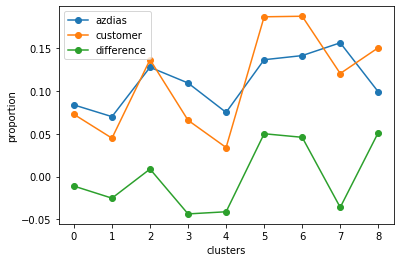

In [64]:
cluster_percentage.plot(marker='o')
plt.xlabel('clusters')
plt.ylabel('proportion')

In [66]:
cluster_percentage_sorted = cluster_percentage.sort_values(by='difference',ascending=False)
cluster_percentage_sorted

,azdias,customer,difference
8,0.099105,0.150665,0.051560
5,0.136660,0.186815,0.050156
6,0.141472,0.187463,0.045991
2,0.127851,0.136743,0.008892
0,0.083836,0.072830,-0.011006
1,0.070121,0.044985,-0.025136
7,0.156426,0.120541,-0.035886
4,0.075102,0.034072,-0.041030
3,0.109428,0.065887,-0.043541


clusters 8 and 5 are the most over-represented in the customer compared to the general population. clusters 3 and 4 are the most under-represented in the customer. Now find out the most important attributes in those clusters.  

### Top attributes

find out the top attributes in the cluster most over-represented (i.e., cluster 8 and 5) and most under-represented (i.e., cluster 3 and 4).

In [86]:
# find the top component in cluster n
def get_top_component(model, n):
    """
    find the component having the highest weights in cluster n of the model
    
    INPUT:
        model: kmeans model 
        n: int, the number of cluster
    
    OUTPUT:
        the number of component having the highest weights 
    """
    weights_of_components = model.cluster_centers_[n]
    components_num = list(range(200))
    weights_components = pd.DataFrame({'Weights': weights_of_components, 'Component': components_num})
    weights_components_sorted = weights_components.sort_values('Weights', ascending=False)
    top_component = weights_components_sorted.iloc[0,1]
    return top_component

In [116]:
# find the component having the highest weights in the cluster most over-represented (i.e., cluster 8)
top_cluster_1 = cluster_percentage_sorted.index[0]
top_component_1 = get_top_component(azdias_model, top_cluster)
top_component_1

1

Component 1 has the highest weights in the cluster most over-represented. find out the top 10 attributes of Component 1. 

In [117]:
def get_top_attributes(component_num, top_num):
    """
    find the top attributes having the highest weights in the component
    
    INPUT:
        component_num: int, the number of component 
        top_num: int, the number of returned attributes
    
    OUTPUT:
        the top attributes, int
    """
    attribute_weights = pd.DataFrame(azdias_pca_200_fit.components_, columns = azdias_new.columns.values)
    attribute_weights = attribute_weights.round(3) 
    top_attributes = attribute_weights.loc[component_num,:].sort_values(ascending=False)[:top_num]
    top_attributes = top_attributes.to_frame().reset_index()
    top_attributes.columns = ['Attribute', 'Value']
    top_attribute_meaning = pd.merge(top_attributes, attributes_information, on='Attribute', how= 'outer')[:top_num]
    top_attribute_meaning = top_attribute_meaning[['Attribute', 'Description']]
    return top_attribute_meaning

In [118]:
top_attributes_1 = get_top_attributes(top_component, 10)
top_attributes_1

,Attribute,Description
0,KBA13_HERST_BMW_BENZ,share of BMW & Mercedes Benz within the PLZ8
1,KBA13_SEG_OBEREMITTELKLASSE,share of upper middle class cars and upper cla...
2,KBA13_MERCEDES,share of MERCEDES within the PLZ8
3,KBA13_BMW,share of BMW within the PLZ8
4,KBA13_SITZE_4,number of cars with less than 5 seats in the PLZ8
5,KBA13_SEG_SPORTWAGEN,share of sportscars within the PLZ8
6,KBA05_HERST1,"share of top German manufacturer (Mercedes, BMW)"
7,KBA13_KMH_211,share of cars with a greater max speed than 21...
8,KBA13_KMH_250,share of cars with max speed between 210 and 2...
9,KBA13_KW_121,share of cars with an engine power more than 1...


Top 10 attributes of cluster 8 are mainly regarding the share of middle and upper class cars.

Now let us find out what are the top 10 attributes from second most over-represented cluster.

In [122]:
top_cluster_2 = cluster_percentage_sorted.index[1]
top_component_2 = get_top_component(azdias_model, top_cluster_2)
top_attributes_2 = get_top_attributes(top_component_2, 10)
top_attributes_2


,Attribute,Description
0,FINANZ_VORSORGER,financial typology: be prepared
1,CJT_TYP_5,NaN
2,ALTERSKATEGORIE_GROB,age classification through prename analysis
3,CJT_TYP_4,NaN
4,CJT_TYP_3,NaN
5,CJT_TYP_6,NaN
6,KOMBIALTER,NaN
7,CJT_KATALOGNUTZER,NaN
8,SEMIO_LUST,affinity indicating in what way the person is ...
9,RETOURTYP_BK_S,return type


Top 10 attributes of second most over-represented cluster are mainly regarding the financial status and age.

Now let us find out what are the top 10 features from the most under_represented clusters.

In [124]:
top_cluster_n1 = cluster_percentage_sorted.index[-1]
top_component_n1 = get_top_component(azdias_model, top_cluster_n1)
top_attributes_n1 = get_top_attributes(top_component_n1, 10)
top_attributes_n1

,Attribute,Description
0,PLZ8_ANTG3,number of 6-10 family houses in the PLZ8
1,KBA13_ANTG3,NaN
2,KBA13_ANTG4,NaN
3,KBA13_BAUMAX,NaN
4,PLZ8_ANTG4,number of >10 family houses in the PLZ8
5,PLZ8_BAUMAX,most common building-type within the PLZ8
6,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup
7,CAMEO_INTL_2015,NaN
8,HH_EINKOMMEN_SCORE,estimated household net income
9,EWDICHTE,density of inhabitants per square kilometer


Top 10 attributes in the most under-represented cluster are mainly regarding the number of family houses, household income, and density of inhabitants. 

Now let us find out what are the top 10 features from the second most under_represented clusters.

In [125]:
top_cluster_n2 = cluster_percentage_sorted.index[-2]
top_component_n2 = get_top_component(azdias_model, top_cluster_n2)
top_attributes_n2 = get_top_attributes(top_component_n2, 10)
top_attributes_n2

,Attribute,Description
0,PLZ8_ANTG3,number of 6-10 family houses in the PLZ8
1,KBA13_ANTG3,NaN
2,KBA13_ANTG4,NaN
3,KBA13_BAUMAX,NaN
4,PLZ8_ANTG4,number of >10 family houses in the PLZ8
5,PLZ8_BAUMAX,most common building-type within the PLZ8
6,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup
7,CAMEO_INTL_2015,NaN
8,HH_EINKOMMEN_SCORE,estimated household net income
9,EWDICHTE,density of inhabitants per square kilometer


Top 10 attributes in the second most under-represented cluster are same as the previous one.

#### Summary: The major attributes in the over-represented population are the share of middle and upper class cars, finanical status, and age. The major attributes in the under-represented population are the number of family houses, household income, and density of inhabitants.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [128]:
mailout_train = pd.read_csv('mailout_train.csv', sep=',')

/Users/lizhen/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [129]:
mailout_train = mailout_train.drop('Unnamed: 0', axis=1)
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [130]:
# clean the train data.
mailout_train = convert_unknown(mailout_train, unknown_values)
mailout_train = cleaning_data(mailout_train)

In [131]:
X = mailout_train.drop('RESPONSE', axis=1)
y = mailout_train['RESPONSE']

In [132]:
X.shape, y.shape

((33836, 322), (33836,))

In [133]:
X.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,1.0,8.0,15.0,0.0,0.0,1.0,13.0,0.0,3.0,...,2.0,5.0,2.0,1.0,6.0,9.0,3.0,3.0,2.0,4.0
1,1771,4.0,13.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,...,3.0,1.0,2.0,1.0,4.0,9.0,7.0,1.0,2.0,3.0
2,1776,1.0,7.0,0.0,NaN,0.0,0.0,1.0,0.0,4.0,...,1.0,6.0,4.0,2.0,NaN,9.0,2.0,3.0,1.0,4.0
3,1460,1.0,6.0,4.0,0.0,0.0,2.0,4.0,0.0,4.0,...,4.0,8.0,11.0,11.0,6.0,9.0,1.0,3.0,2.0,4.0
4,1783,1.0,9.0,53.0,0.0,0.0,1.0,44.0,0.0,3.0,...,4.0,2.0,2.0,1.0,6.0,9.0,3.0,3.0,1.0,3.0


In [134]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: RESPONSE, dtype: int64

In [135]:
y.value_counts()

0    33420
1      416
Name: RESPONSE, dtype: int64

Since the response is imbalanced, ROC_AUC is used for evaluation.

In [136]:
# impute NaNs 

imputer = Imputer()
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# feature scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

/Users/lizhen/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [137]:
X.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,-1.651088,-0.291073,-0.426679,0.570368,-1.301827e-01,-0.221419,-0.757347,0.499417,-0.09117,-0.040910,...,-0.332638,0.220948,-0.759365,-0.833678,8.175199e-01,0.24578,-0.522558,0.208638,0.855611,0.584472
1,-1.650767,1.488713,0.734491,-0.372609,-1.301827e-01,-0.221419,-0.024873,-0.365203,-0.09117,-1.009610,...,0.544732,-1.049677,-0.759365,-0.833678,-3.577132e-01,0.24578,1.449423,-1.426259,0.855611,-0.647460
2,-1.650567,-0.291073,-0.658913,-0.439965,1.894710e-17,-0.221419,-1.489820,-0.365203,-0.09117,0.927789,...,-1.210007,0.538605,-0.146508,-0.434415,-5.219083e-16,0.24578,-1.015554,0.208638,-1.168755,0.584472
3,-1.663245,-0.291073,-0.891147,-0.170543,-1.301827e-01,-0.221419,-0.024873,-0.149048,-0.09117,0.927789,...,1.422101,1.173918,1.998492,3.158949,8.175199e-01,0.24578,-1.508549,0.208638,0.855611,0.584472
4,-1.650286,-0.291073,-0.194445,3.129879,-1.301827e-01,-0.221419,-0.757347,2.733018,-0.09117,-0.040910,...,1.422101,-0.732021,-0.759365,-0.833678,8.175199e-01,0.24578,-0.522558,0.208638,-1.168755,-0.647460


In [138]:
def classifier(estimator, param_grid, X=X, y=y):
    grid = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring='roc_auc', cv=5)
    grid.fit(X, y)
    print('Estimator:', grid.best_estimator_)
    print('Score:', grid.best_score_)
    
    return grid.best_estimator_

In [139]:
# compare four estimators
estimators = [LogisticRegression(random_state=42), RandomForestClassifier(random_state=42), AdaBoostClassifier(random_state=42), GradientBoostingClassifier(random_state=42)]
for estimator in estimators:
    classifier(estimator, {})

/Users/lizhen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/lizhen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/lizhen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/lizhen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/lizhen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to '

Estimator: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Score: 0.6826267017842153


/Users/lizhen/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/lizhen/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/lizhen/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/lizhen/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/lizhen/anaconda3/lib/python3.7/si

Estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
Score: 0.522727296007536
Estimator: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=42)
Score: 0.7599693943462748
Estimator: GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_it

GradientBoostingClassifier gives the highest score of 0.78. Choose GradientBoostingClassifier as the estimator and optimize it using GridSearchCV.

In [182]:
estimator = GradientBoostingClassifier(random_state=42)
param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [10, 100, 200]
}
best_estimator = classifier(estimator, param_grid)

Estimator: GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
Score: 0.7786042320651118


The optimized parameters are learning_rate = 0.1 and n_estimators=100.

In [183]:
best_estimator

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
# mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [203]:
mailout_test = pd.read_csv('mailout_test.csv', sep=',')

/Users/lizhen/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [204]:
mailout_test.shape

(42833, 367)

In [205]:
mailout_test.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [206]:
mailout_test = mailout_test.drop('Unnamed: 0', axis=1)

In [207]:
mailout_test = convert_unknown(mailout_test, unknown_values)

In [208]:
# define a new cleaning process keeping all rows
def cleaning_data_keeprows(data):
    """
    cleaning data
    
    INPUT:
        data: demographic dataframe 
    
    OUTPUT:
        demographic dataframe with clean data for machine learning
    """
    
    # proportion of missing value in each column
    missing_value_col = data.isnull().sum()/ data.shape[0]
           
    # drop the columns which are dropped in azdias dataset
    col_missing_to_drop = ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3',
       'ALTER_KIND4', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24',
       'D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24',
       'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM',
       'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM',
       'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM',
       'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24',
       'EXTSEL992', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4',
       'KBA05_BAUMAX', 'KBA05_MAXVORB', 'KK_KUNDENTYP', 'LP_STATUS_GROB',
       'TITEL_KZ']
    data_new = data.drop(col_missing_to_drop, axis=1)
    
    # process object data type
    data_object = data_new.select_dtypes(include=['object'])
    
    # reencode 'X' in CAMEO_DEUG_2015 and 'XX' in CAMEO_INTL_2015 with NaNs
    # convert CAMEO_DEUG_2015 and CAMEO_INTL_2015 to float
    data_new['CAMEO_DEUG_2015'].replace('X', np.nan, inplace=True)
    data_new['CAMEO_INTL_2015'].replace('XX', np.nan, inplace=True)

    col_to_float = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']
    data_new[col_to_float] = data_new[col_to_float].astype(float)

    # reencode 'W' and 'O' in OST_WEST_KZ with 1 and 0
    data_new['OST_WEST_KZ'].replace({'W': 1, 'O': 0}, inplace=True)
    
    # drop column CAMEO_DEU_2015, D19_LETZTER_KAUF_BRANCHE, EINGEFUEGT_AM
    col_to_drop = ['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM']
    data_new.drop(col_to_drop, axis=1, inplace=True)
    
    return data_new

In [209]:
mailout_test = cleaning_data_keeprows(mailout_test)

In [210]:
LNR = mailout_test['LNR']

In [211]:
mailout_test = pd.DataFrame(imputer.fit_transform(mailout_test), columns=mailout_test.columns)
mailout_test = pd.DataFrame(scaler.fit_transform(mailout_test), columns=mailout_test.columns)

In [212]:
mailout_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42833 entries, 0 to 42832
Columns: 322 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(322)
memory usage: 105.2 MB


In [213]:
mailout_pred_proba = best_estimator.predict_proba(mailout_test)

In [214]:
pd.DataFrame(mailout_pred_proba).head()

,0,1
0,0.972569,0.027431
1,0.984591,0.015409
2,0.914358,0.085642
3,0.997357,0.002643
4,0.963901,0.036099


In [215]:
df = pd.DataFrame({'LNR': LNR, 'RESPONSE': mailout_pred_proba[:, 1]})

In [219]:
df[df['RESPONSE']>0.5].head()

,LNR,RESPONSE
179,24149,0.788196
1121,60672,0.558427
1627,27506,0.521961
3359,38169,0.623118
3771,69500,0.761400


In [217]:
df.to_csv('submission.csv', index=False)

Submit to Kaggle, and the score is 0.68.